<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#ДЗ:-Временные-ряды" data-toc-modified-id="ДЗ:-Временные-ряды-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>ДЗ: Временные ряды</a></span><ul class="toc-item"><li><span><a href="#anti-diabetic-drugs" data-toc-modified-id="anti-diabetic-drugs-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>anti-diabetic-drugs</a></span></li><li><span><a href="#female-births" data-toc-modified-id="female-births-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>female-births</a></span></li><li><span><a href="#shampoo" data-toc-modified-id="shampoo-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>shampoo</a></span></li></ul></li></ul></div>

# ДЗ: Временные ряды



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 5)

In [2]:
import statsmodels.api as sm # все, для работы с рядами
from scipy.special import inv_boxcox # обратное преобразование Бокса-Кокса 
from itertools import product # произведения множеств
import warnings # чтобы отключить предупреждения в Python
from tqdm.notebook import tqdm

In [3]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/elenaefimova/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [4]:
plt.style.use('ggplot')

Есть 3 датасета с временными рядами
- В `anti-diabetic-drugs.csv` содержатся данные о ежемесячных продажах антидиабетических препаратов в Австралии с 1992 по 2008 год. 
- В `female-births.csv` содержатся данные о количестве новорожденных детей женского пола в 1959 году в Калифорнии. 
- В `shampoo.csv` содержатся данные о ежемесячных продажах шампуня за трехлетний период. 


Проанализируйте каждый из этих рядов и постройте модель SARIMA, чтобы сделать прогноз
- для `anti-diabetic-drugs.csv` - на один год вперед
- для `female-births.csv` - на один месяц вперед
- для `shampoo.csv` - на 3 месяца вперед

Для этого 
- рассмотрите необходимость стабилизации дисперссии и необходимость дифференцирования ряда
- проанализируйте ACF и PACF и подберите гиперпараметры SARIMA
- обучите модель SARIMA с наилучшими гиперпараметрами
- проанализируйте остатки модели

Ваши решения необходимо сопроводить краткими комментариями и выводами, которые Вы сделали на основе анализа. Не забывайте о построении графиков! 

Ориентируйтесь на пример анализа временного ряда в ноутбуке с последнего занятия.

## anti-diabetic-drugs

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


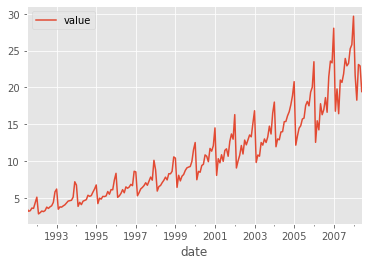

In [7]:
data = pd.read_csv('./data/anti-diabetic-drugs.csv', index_col='date', parse_dates=['date'])
data.plot();
data.head()

In [8]:
# На графике видим сезонность и общий тренд. Также дисперсия ряда возрастает со временем
# Сдвинем данные на 12 месяцев, чтобы посчитать автокорреляцию

data['lag_12']= data['value'].shift(12)

In [11]:
data.corr()

# продажи, которые были год назад, очень похожи на след год. Коэф-т корреляции равен 0.982913

,value,lag_12
value,1.000000,0.982913
lag_12,0.982913,1.000000


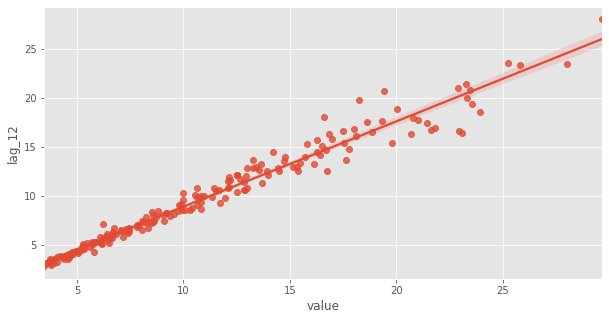

In [15]:
sns.regplot(data=data, x='value', y='lag_12')
plt.show()

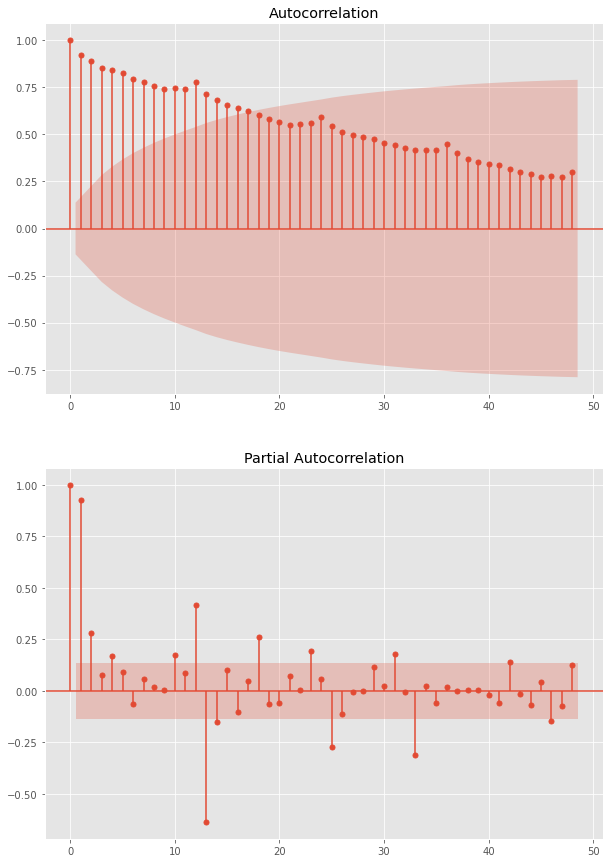

In [41]:
# по ОХ - корреляции, по ОУ - лаги

fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(10,15)) 

sm.graphics.tsa.plot_acf(data['value'], lags=48, ax=ax1)
sm.graphics.tsa.plot_pacf(data['value'], lags=48, ax=ax2)

plt.show()

# Для временных рядов с трендом и сезонностью соответствует функция на первой картинке 

In [43]:
data.value.isnull().sum()

0

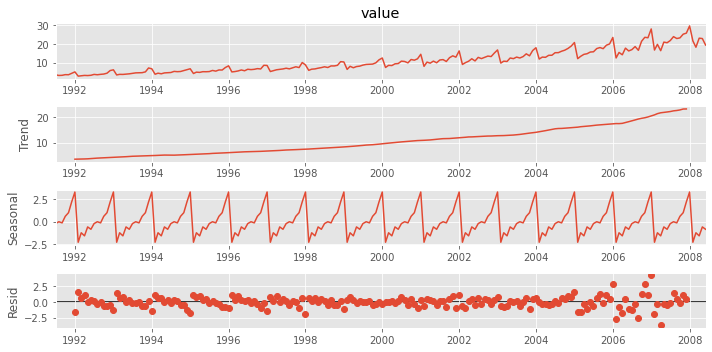

In [53]:
sm.tsa.seasonal_decompose(data.value).plot()
plt.show()

In [11]:
# Приведем ряд к стационарному виду
# 1. Стабилизация дисперсии (по Боксу-Коксу)
  
data['value_boxcox'], lmbd = stats.boxcox(data['value'])
print("Оптимальный параметр преобразования Бокса-Кокса: ",lmbd)

Оптимальный параметр преобразования Бокса-Кокса:  0.061505584870954325


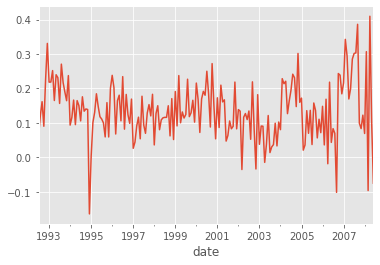

In [12]:
# Удаление сезонности - сделаем дифференцирование

data['value_diff'] = data.value_boxcox - data.value_boxcox.shift(12)
data.value_diff[12:].plot()

plt.show() 

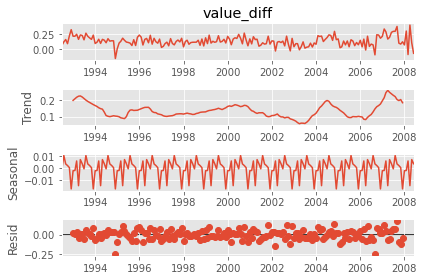

In [13]:
sm.tsa.seasonal_decompose(data.value_diff[12:]).plot()
plt.show()

Теперь наш ряд стал похож на стационарный. Попробуем формально отвергнуть гипотезу о нестационарности с помощью критерия Дики-Фуллера.

In [50]:
print("Критерий Дики-Фуллера для преобразованного ряда: pvalue =",
      sm.tsa.stattools.adfuller(data.value_diff[12:])[1])

# Гипотеза о нестационарности отвергается

Критерий Дики-Фуллера для преобразованного ряда: pvalue = 5.437793682127199e-06
0.00000544


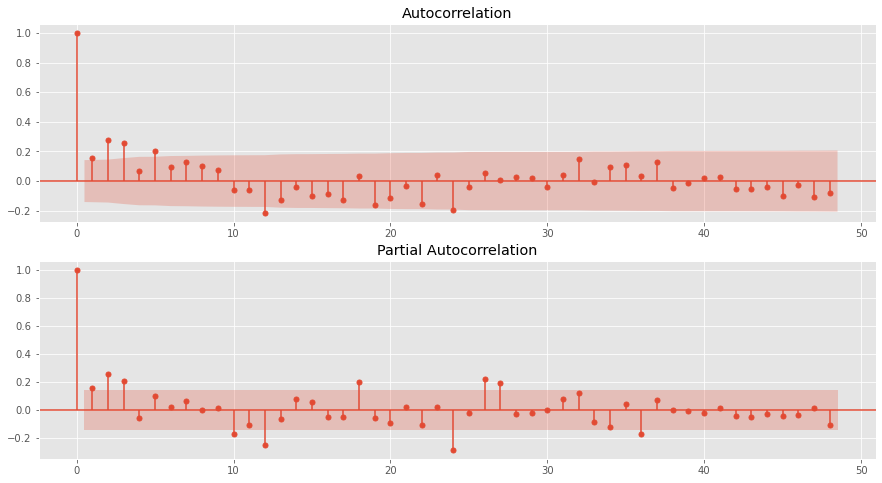

In [33]:
fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(15,8)) 

sm.graphics.tsa.plot_acf(data.value_diff[12:].values.squeeze(), lags=48, ax=ax1)
sm.graphics.tsa.plot_pacf(data.value_diff[12:].values.squeeze(), lags=48, ax=ax2)

plt.show()

Начальные значения $Q=2$, $q=3$, $P=3$, $p=3$. 

In [5]:
from itertools import product
# создадим список из значений параметров для перебора моделей

s = 12 # сезонность
d = D = 1
ps = range(0, 3+1)
qs = range(0, 3+1)

Ps = range(0, 3+1)
Qs = range(0, 2+1)

parameters = product(ps ,qs, Ps, Qs)
parameters_list = list(parameters)

In [14]:
# SARIMAX(p,d,q)x(P,D,Q,s)
results = [] # здесь будем хранить результаты
warnings.filterwarnings('ignore') # не для всех параметров модели будут обучаться; отключим предупреждения

for param in tqdm(parameters_list):
    #try-except нужен, чтобы обработать случаи, когда модель не обучается
    p, q, P, Q = param
    try:
        model=sm.tsa.statespace.SARIMAX(data.value_boxcox,  #sales_boxcox или sales
            order=(p, d, q), 
            seasonal_order=(P, D, Q, s)).fit(disp=-1)
    
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('Wrong parameters:', param)
        continue
    
    results.append([param, model.aic])

  0%|          | 0/192 [00:00<?, ?it/s]

In [15]:
result_table = pd.DataFrame(results)
result_table.columns = ['Parameters', 'AIC']
result_table.sort_values(by = 'AIC', ascending=True).head()

,Parameters,AIC
139,"(2, 3, 2, 1)",-466.194708
175,"(3, 2, 2, 1)",-465.976152
163,"(3, 1, 2, 1)",-465.770991
170,"(3, 2, 0, 2)",-464.071132
176,"(3, 2, 2, 2)",-463.899114


In [16]:
# Выведем лучшую модель с параметрами

best_model = sm.tsa.statespace.SARIMAX(data.value_boxcox, 
                                     order=(2,1,3), 
                                     seasonal_order=(2,1,1,12)).fit(disp=-1)

print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                         value_boxcox   No. Observations:                  204
Model:             SARIMAX(2, 1, 3)x(2, 1, [1], 12)   Log Likelihood                 242.097
Date:                              Sun, 24 Jul 2022   AIC                           -466.195
Time:                                      16:57:27   BIC                           -436.924
Sample:                                  07-01-1991   HQIC                          -454.339
                                       - 06-01-2008                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9435      0.086    -10.953      0.000      -1.112      -0.775
ar.L2         -0.86

**Анализ остатков**

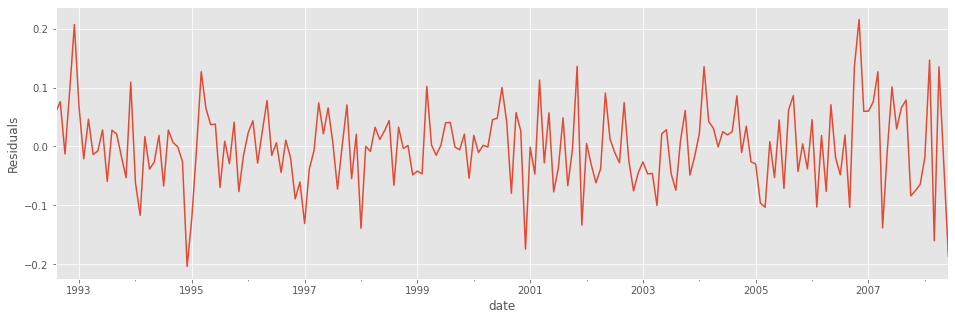

In [17]:
plt.figure(figsize(16,5))
best_model.resid[13:].plot()
plt.ylabel('Residuals')
plt.show()

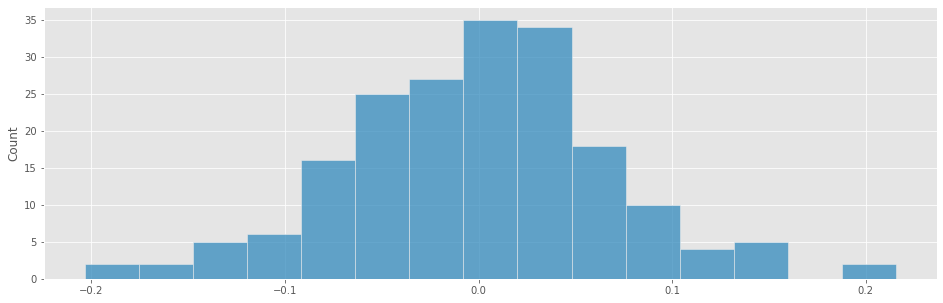

In [18]:
# Распределение похоже на нормальное


sns.histplot(best_model.resid[13:]);

In [19]:
#  Проверим несмещенность с помощью критерия знаков

from statsmodels.stats.descriptivestats import sign_test
print("Критерий знаков для остатков: pvalue =",
      sign_test(best_model.resid[13:])[1])

# Медиана остатков не отличается от нуля, тк pvalue = 1.0

Критерий знаков для остатков: pvalue = 1.0


In [21]:
# Проверим гипотезу о не стационарности

print("Критерий Дики-Фуллера для остатков: pvalue =",
      sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

# Гипотеза о нестационарности отвергается

Критерий Дики-Фуллера для остатков: pvalue = 3.2121740792251485e-24


<Figure size 1152x360 with 0 Axes>

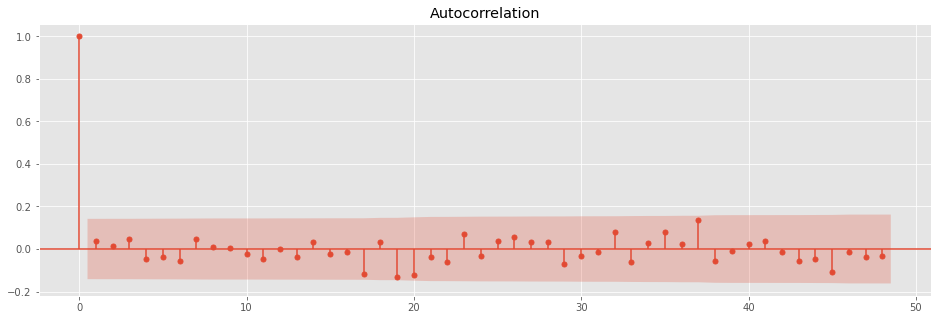

In [22]:
plt.figure(figsize(16,5))
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48)
plt.show()

# Значимых корреляций нет 

Заметим в модели, что по критерию Льюнга-Бокса не отвергается нулевая гипотеза о независимости отстатков

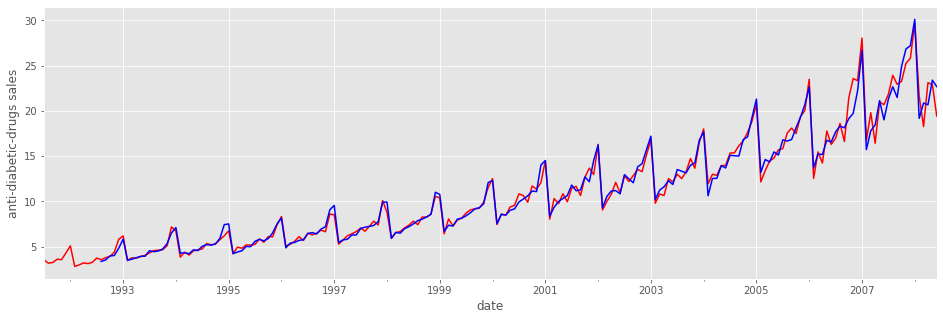

In [25]:
# Посмотрим на модель
# Колебания графиков довольны похожи

data['model'] = inv_boxcox(best_model.fittedvalues, lmbd)
plt.figure(figsize(16,5))
data.value.plot(color='r')
data.model[13:].plot(color='b')

plt.ylabel('anti-diabetic-drugs sales')
pylab.show()

**Прогноз**

In [29]:
plot_data = data[['value','model']]

date_list = [datetime.datetime.strptime("2008-06-01", "%Y-%m-%d") + relativedelta(months=x) 
             for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= plot_data.columns)
plot_data = pd.concat([plot_data, future])

plot_data.tail()

,value,model
2011-01-01,NaN,NaN
2011-02-01,NaN,NaN
2011-03-01,NaN,NaN
2011-04-01,NaN,NaN
2011-05-01,NaN,NaN


In [30]:
start = data.shape[0]
start

204

In [31]:
# построим предсказание на 3 года, сделаем для него обратное преобразование Бокса-Кокса

forecast = inv_boxcox(best_model.predict(start=start, end=start+35), lmbd)
forecast.index = date_list

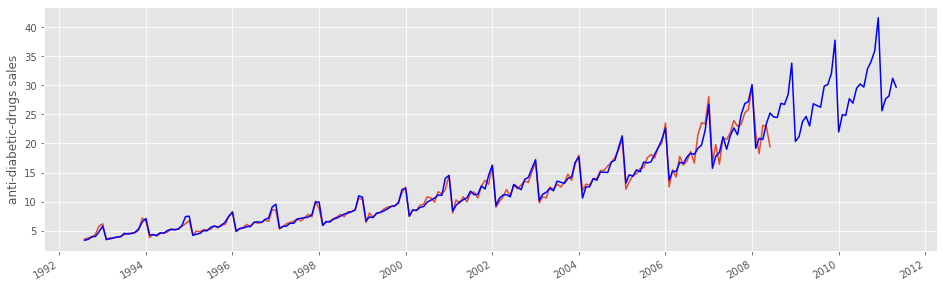

In [34]:
plot_data.loc[date_list, 'model'] = forecast

plt.figure(figsize(16,5))
plot_data.value[13:].plot()
plot_data.model[13:].plot(color='b')
plt.ylabel('anti-diabetic-drugs sales')
pylab.show()

## female-births

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


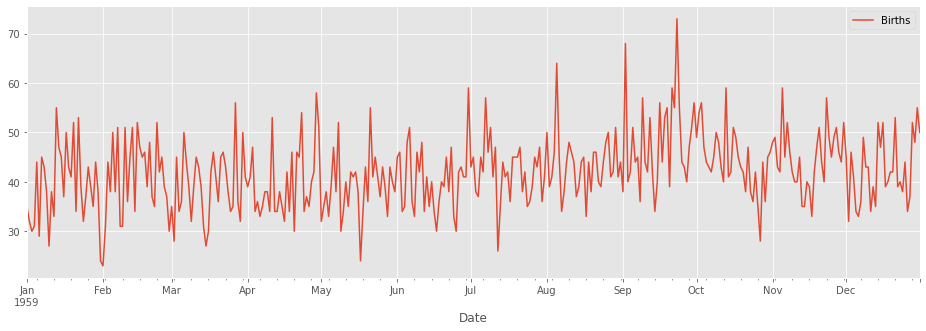

In [420]:
df = pd.read_csv('./data/female-births.csv', index_col=['Date'], parse_dates=['Date'])
df.plot();
df.head()

# Нет заметного тренда или цикличности в ряде 

In [38]:
data.value.isnull().sum()

0

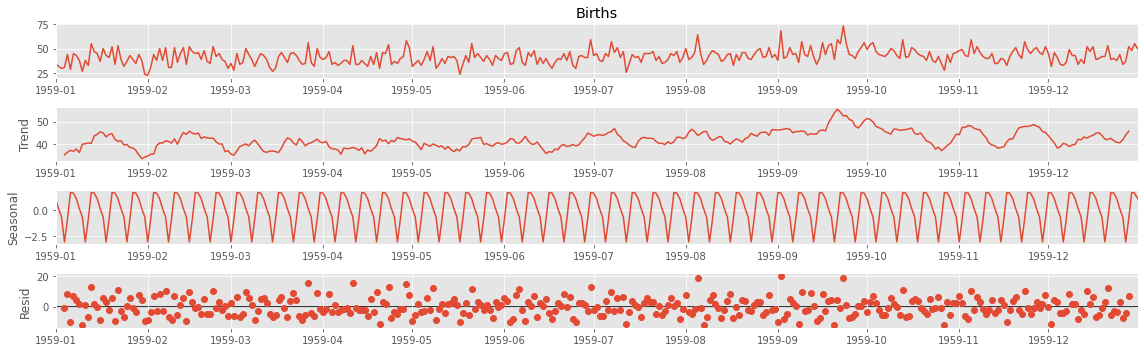

In [39]:
sm.tsa.seasonal_decompose(df.Births).plot()
plt.show()

In [428]:
# Приведем ряд к стационарному виду
# Стабилизируем дисперсии (по Боксу-Коксу)
  
df['births_box'], lmbd = stats.boxcox(df.Births)
print("Оптимальный параметр преобразования Бокса-Кокса: ",lmbd)

Оптимальный параметр преобразования Бокса-Кокса:  0.28961358249748603


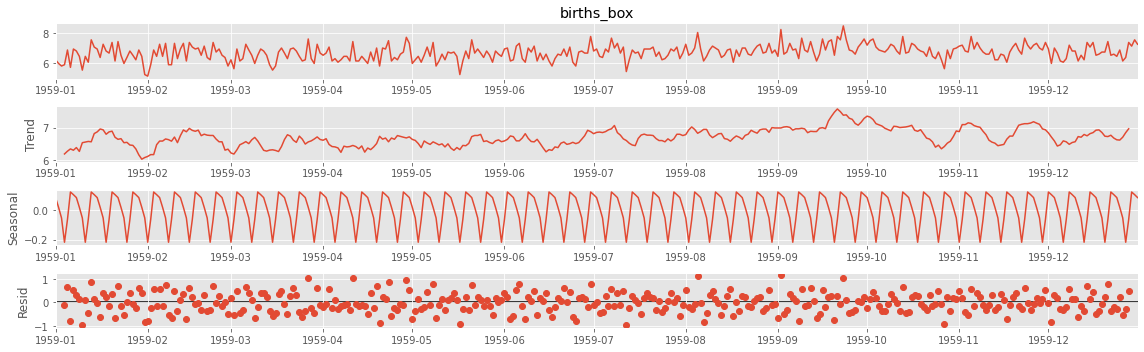

In [45]:
sm.tsa.seasonal_decompose(df.births_box).plot()
plt.show()

In [52]:
# Проверим формально гипотезу о нестационарности ряда

print("Критерий Дики-Фуллера для преобразованного ряда: pvalue =",
      sm.tsa.stattools.adfuller(df.births_box)[1])

# Гипотеза о нестационарности отвергается

Критерий Дики-Фуллера для преобразованного ряда: pvalue = 0.0003719724072617037


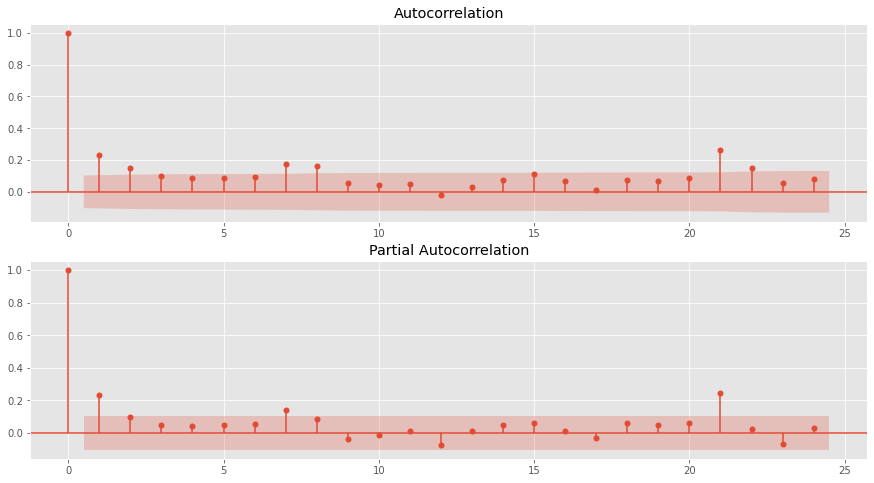

In [90]:
fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(15,8)) 

sm.graphics.tsa.plot_acf(df.births_box.values.squeeze(), lags=24, ax=ax1)
sm.graphics.tsa.plot_pacf(df.births_box.values.squeeze(), lags=24, ax=ax2)

plt.show()

Начальные значения $Q=3$, $q=2$, $P=2$, $p=1$.  

In [276]:
from itertools import product
# создадим список из значений параметров для перебора моделей

s = 4
d = D = 1
ps = range(0, 1+1)
qs = range(0, 2+1)

Ps = range(0, 2+1)
Qs = range(0, 3+1)

parameters = product(ps ,qs, Ps, Qs)
parameters_list = list(parameters)

In [429]:
# SARIMAX(p,d,q)x(P,D,Q,s)
results = []
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    p, q, P, Q = param
    try:
        model=sm.tsa.statespace.SARIMAX(df.births_box,  
            order=(p, d, q), 
            seasonal_order=(P, D, Q, s)).fit(disp=-1)
    

    except ValueError:
        print('Wrong parameters:', param)
        continue
    
    results.append([param, model.aic])

  0%|          | 0/36 [00:00<?, ?it/s]

In [436]:
result_table = pd.DataFrame(results)
result_table.columns = ['Parameters', 'AIC']
result_table.sort_values(by = 'AIC', ascending=True).head()

,Parameters,AIC
28,"(1, 1, 0, 1)",547.747774
31,"(1, 1, 1, 1)",549.491767
29,"(1, 1, 0, 2)",549.516536
34,"(1, 1, 2, 1)",550.707272
32,"(1, 1, 1, 2)",550.942384


In [433]:
# Выберем вторую модель, тк меньше параметров

best_model = sm.tsa.statespace.SARIMAX(df.births_box, 
                                     order=(1, 1, 1),
                                    seasonal_order=(0, 1, 1, 4)).fit(disp=-1)
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                        births_box   No. Observations:                  365
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 4)   Log Likelihood                -266.513
Date:                           Wed, 27 Jul 2022   AIC                            541.026
Time:                                   18:45:27   BIC                            556.570
Sample:                               01-01-1959   HQIC                           547.207
                                    - 12-31-1959                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1402      0.057      2.471      0.013       0.029       0.251
ma.L1         -0.9651      0.021    -46.710

**Анализ остатков**

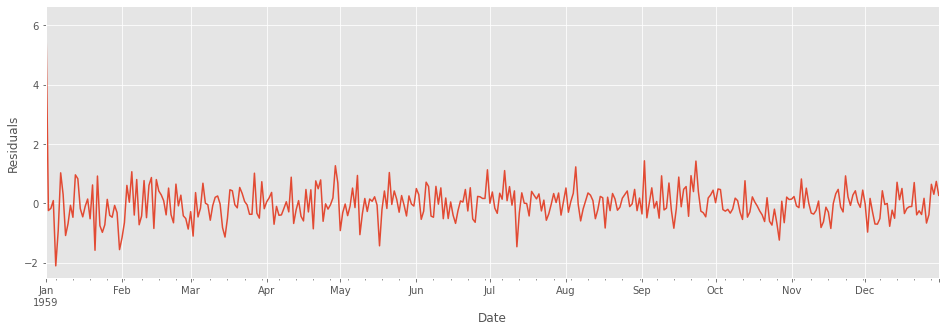

In [437]:
plt.figure(figsize(16,5))
best_model.resid.plot()
plt.ylabel('Residuals')
plt.show()

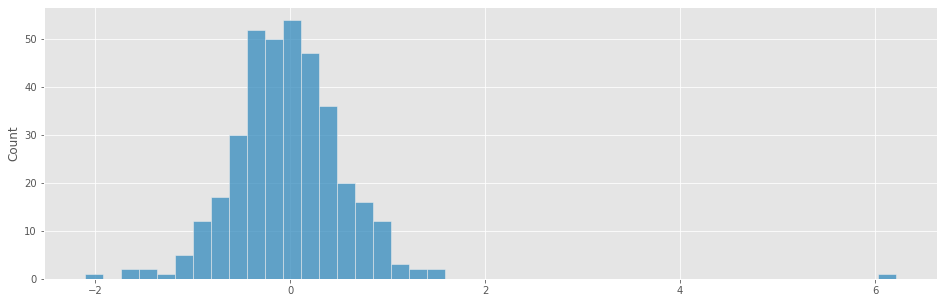

In [438]:
# Распределение напоминает нормальное

sns.histplot(best_model.resid);

In [440]:
#  Проверим несмещенность с помощью критерия знаков

from statsmodels.stats.descriptivestats import sign_test
print("Критерий знаков для остатков: pvalue =",
      sign_test(best_model.resid)[1])

# Медиана остатков не равна нулю. Есть смещение

Критерий знаков для остатков: pvalue = 0.14265623056495516


In [441]:
# Проверим гипотезу о не стационарности

print("Критерий Дики-Фуллера для остатков: pvalue =",
      sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

# Гипотеза о нестационарности отвергается

Критерий Дики-Фуллера для остатков: pvalue = 0.0


Также заметим в модели, что по критерию Льюнга-Бокса не отвергается нулевая гипотеза о независимости отстатков

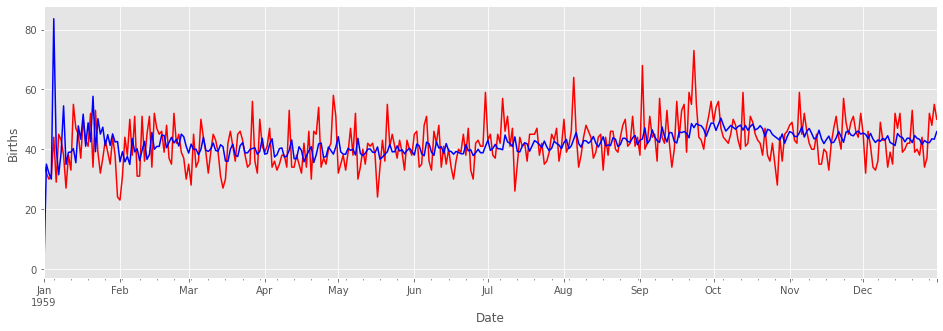

In [442]:
# Посмотрим на модель
# Основная линия тренда похожа, но дисперсия колебаний у наблюдений намного выше. В модели усредненная линия

df['model'] = inv_boxcox(best_model.fittedvalues, lmbd)
plt.figure(figsize(16,5))
df.Births.plot(color='r')
df.model.plot(color='b')

plt.ylabel('Births')
pylab.show()

**Прогноз**

In [291]:
plot_data = df[['Births','model']]

date_list = [datetime.datetime.strptime("1960-01-01", "%Y-%m-%d") + relativedelta(days=x) 
             for x in range(0,180)]
future = pd.DataFrame(index=date_list, columns= plot_data.columns)
plot_data = pd.concat([plot_data, future])

plot_data.tail()

,Births,model
1960-06-24,NaN,NaN
1960-06-25,NaN,NaN
1960-06-26,NaN,NaN
1960-06-27,NaN,NaN
1960-06-28,NaN,NaN


In [292]:
# сколько дней было при обучении модели
start = df.shape[0]
start

365

In [302]:
# построим предсказание на полгода, сделаем для него обратное преобразование Бокса-Кокса

forecast = inv_boxcox(best_model.predict(start=start, end=start+179), lmbd)
forecast.index = date_list

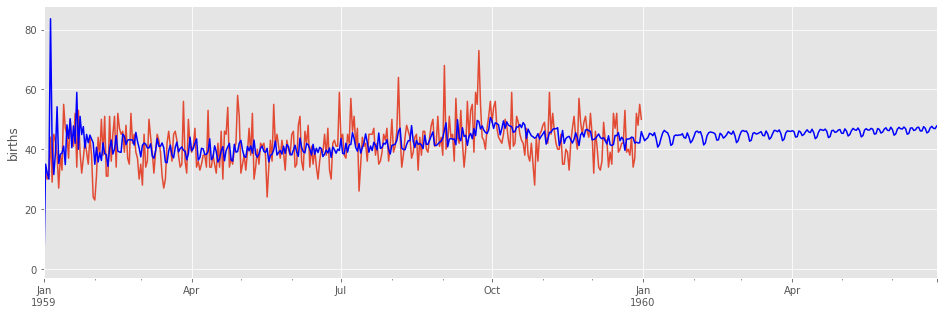

In [303]:
plot_data.loc[date_list, 'model'] = forecast

plt.figure(figsize(16,5))
plot_data.Births.plot()
plot_data.model.plot(color='b')
plt.ylabel('births')
pylab.show()

# Модель хорошо описывает основную линию, но разброс значений не похож

## shampoo

,Sales
Date,
2001-01-01,266.0
2001-02-01,145.9
2001-03-01,183.1
2001-04-01,119.3
2001-05-01,180.3


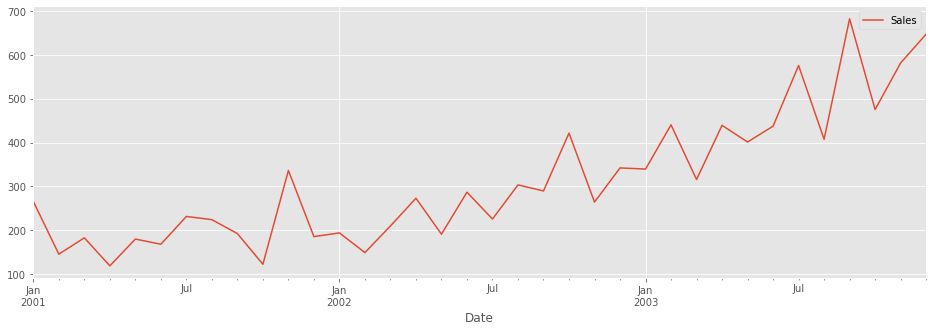

In [370]:
data = pd.read_csv('./data/shampoo.csv')
data['Date'] = pd.to_datetime('200'+data['Month']+'-01')
data = data.set_index('Date').drop('Month',axis=1)
data.plot();
data.head()

In [335]:
# На графике видим общий тренд и возможно цикличность. Сдвинем данные на 11 месяцев, чтобы посчитать автокорреляцию

data['lag_11']= data['Sales'].shift(11)

In [336]:
data.corr()

# коэффициент корреляции выше среднего 0.763993

,Sales,lag_11
Sales,1.000000,0.763993
lag_11,0.763993,1.000000


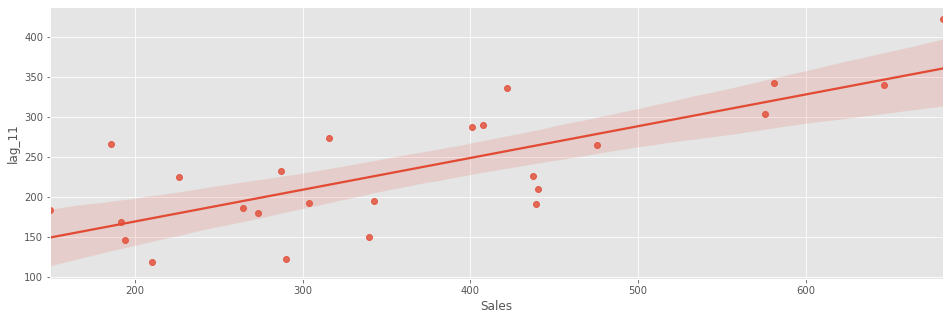

In [337]:
sns.regplot(data=data, x='Sales', y='lag_11')
plt.show()

# видно, что лаги рядом с Sales, но нет явной зависимости

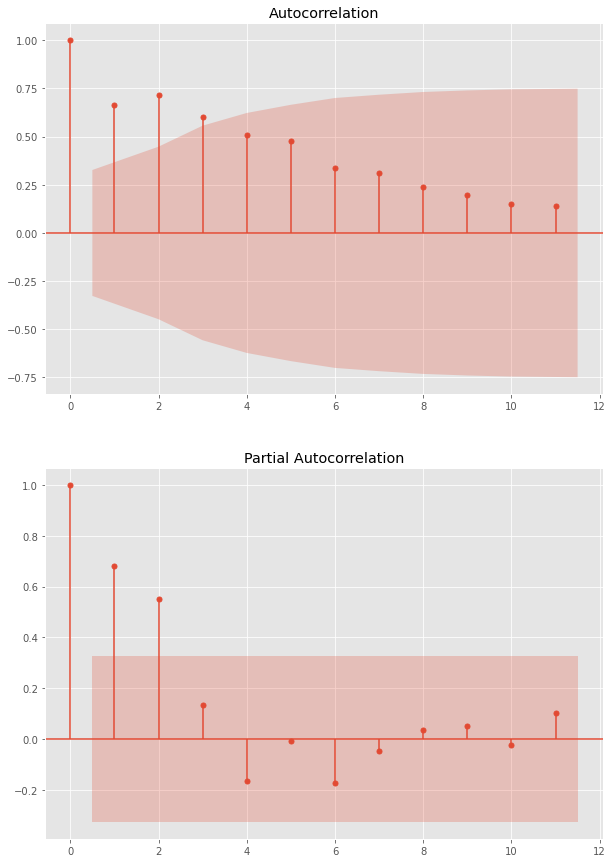

In [190]:
# по ОХ - корреляции, по ОУ - лаги

fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(10,15)) 

sm.graphics.tsa.plot_acf(data['Sales'], lags=11, ax=ax1)
sm.graphics.tsa.plot_pacf(data['Sales'], lags=11, ax=ax2)

plt.show()

In [191]:
data.Sales.isnull().sum()

0

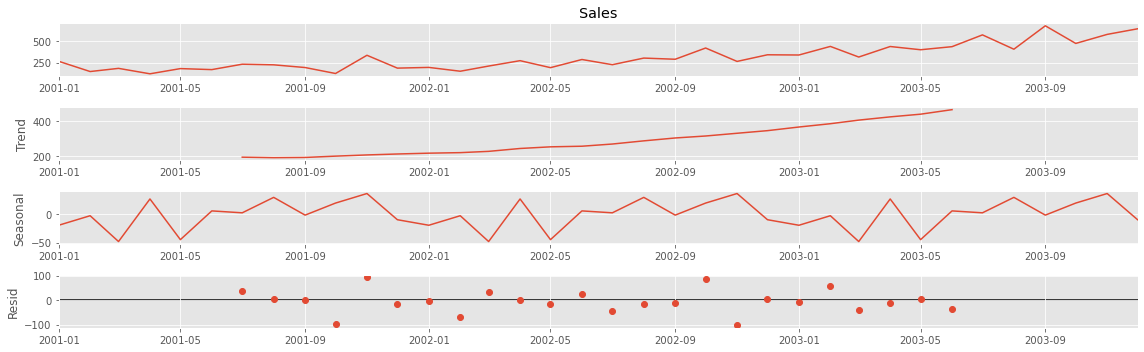

In [192]:
sm.tsa.seasonal_decompose(data.Sales).plot()
plt.show()

In [389]:
# Приведем ряд к стационарному виду
# 1. Стабилизация дисперсии (по Боксу-Коксу)
  
data['sales_boxcox'], lmbd = stats.boxcox(data.Sales)
print("Оптимальный параметр преобразования Бокса-Кокса: ",lmbd)

Оптимальный параметр преобразования Бокса-Кокса:  -0.09471316578026066


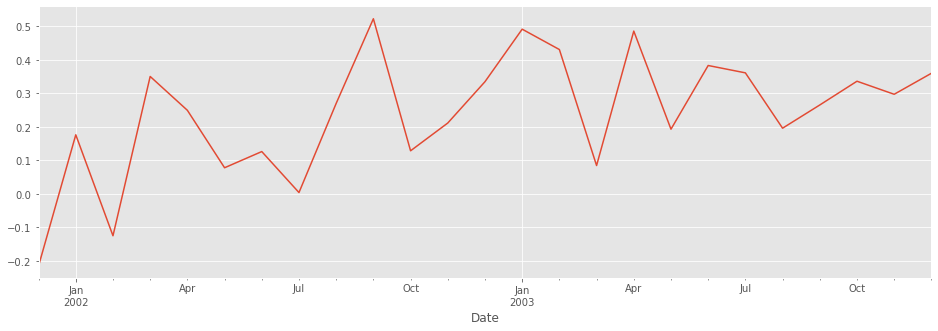

In [339]:
# Удаление сезонности - сделаем дифференцирование

data['sales_diff'] = data.sales_boxcox - data.sales_boxcox.shift(11)
data.sales_diff[11:].plot()

plt.show() 

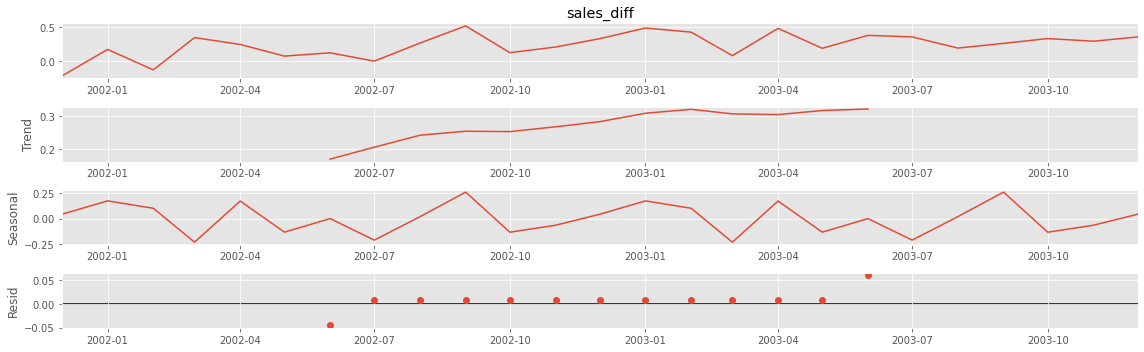

In [340]:
sm.tsa.seasonal_decompose(data.sales_diff[11:]).plot()
plt.show()

Видим, что после сезонного дифференцирования пропала только сезонность, но ряд не стал стационарным  (например, потому что у него есть заметный тренд). Сделаем еще одно обычное дифференцирование.

In [341]:
data['sales_diff_diff2'] = data.sales_diff - data.sales_diff.shift(1)

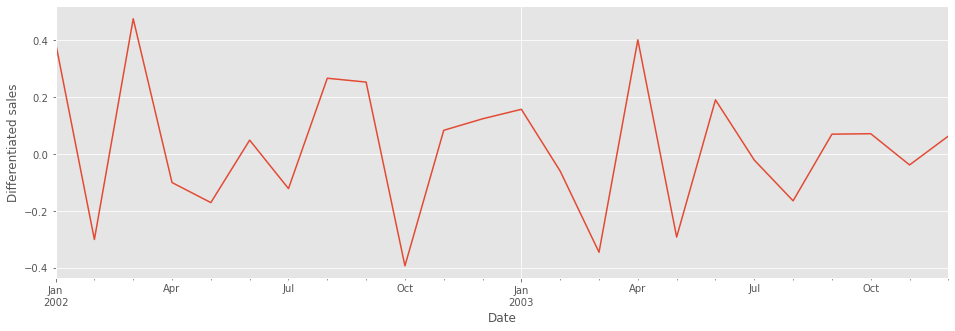

In [342]:
plt.figure(figsize(16,5))
data.sales_diff_diff2[12:].plot()
plt.ylabel('Differentiated sales')
plt.show()

Теперь наш ряд стал похож на стационарный. Попробуем формально отвергнуть гипотезу о нестационарности с помощью критерия Дики-Фуллера.

In [343]:
print("Критерий Дики-Фуллера для преобразованного ряда: pvalue =",
      sm.tsa.stattools.adfuller(data.sales_diff_diff2[12:])[1])

# Отвергаем гипотезу о стационарности на уровне  95%

Критерий Дики-Фуллера для преобразованного ряда: pvalue = 0.05422966270546761


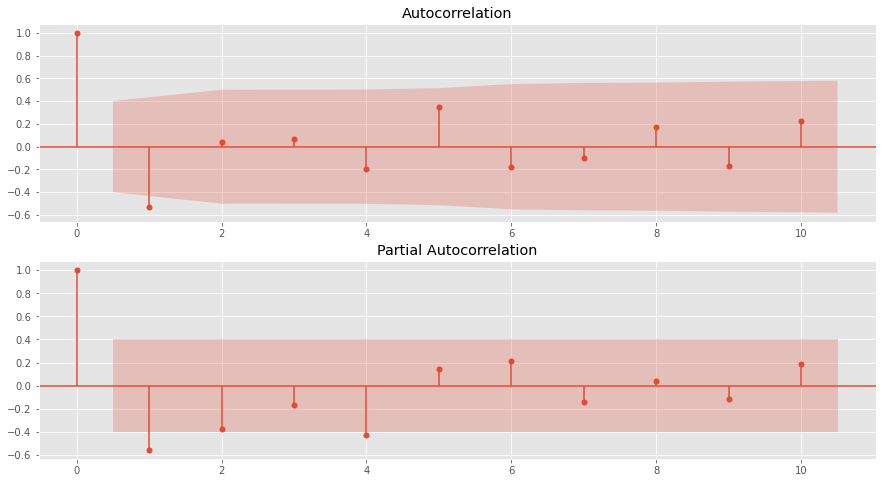

In [310]:
fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(15,8)) 

sm.graphics.tsa.plot_acf(data.sales_diff_diff2[12:].values.squeeze(), lags=10, ax=ax1)
sm.graphics.tsa.plot_pacf(data.sales_diff_diff2[12:].values.squeeze(), lags=10, ax=ax2)

plt.show()

Согласно этим графикам, в качестве начальных значений необходимо взять: $Q=2$, $q=1$, $P=2$, $p=1$.

In [322]:
s = 11
d = D = 1
ps = range(0, 1+1)
qs = range(0, 1+1)

Ps = range(0, 2+1)
Qs = range(0, 2+1)

parameters = product(ps ,qs, Ps, Qs)
parameters_list = list(parameters)

In [371]:
# SARIMAX(p,d,q)x(P,D,Q,s)
results = [] 
warnings.filterwarnings('ignore') 

for param in tqdm(parameters_list):
    p, q, P, Q = param
    try:
        model=sm.tsa.statespace.SARIMAX(data.Sales,
            order=(p, d, q), 
            seasonal_order=(P, D, Q, s)).fit(disp=-1)
    
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('Wrong parameters:', param)
        continue
    
    results.append([param, model.aic])

  0%|          | 0/36 [00:00<?, ?it/s]

In [372]:
result_table = pd.DataFrame(results)
result_table.columns = ['Parameters', 'AIC']
result_table.sort_values(by = 'AIC', ascending=True).head()

,Parameters,AIC
27,"(1, 1, 0, 0)",280.266874
9,"(0, 1, 0, 0)",280.944578
18,"(1, 0, 0, 0)",281.330239
30,"(1, 1, 1, 0)",282.200633
28,"(1, 1, 0, 1)",282.201506


In [373]:
# Выведем лучшую модель с параметрами

best_model = sm.tsa.statespace.SARIMAX(data.Sales, 
                                     order=(1,1,1), 
                                     seasonal_order=(0,1,0,s)).fit(disp=-1)

print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                   36
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 11)   Log Likelihood                -137.133
Date:                             Wed, 27 Jul 2022   AIC                            280.267
Time:                                     18:26:31   BIC                            283.801
Sample:                                 01-01-2001   HQIC                           281.204
                                      - 12-01-2003                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4167      0.365     -1.143      0.253      -1.131       0.298
ma.L1         -0.4742      

**Анализ остатков**

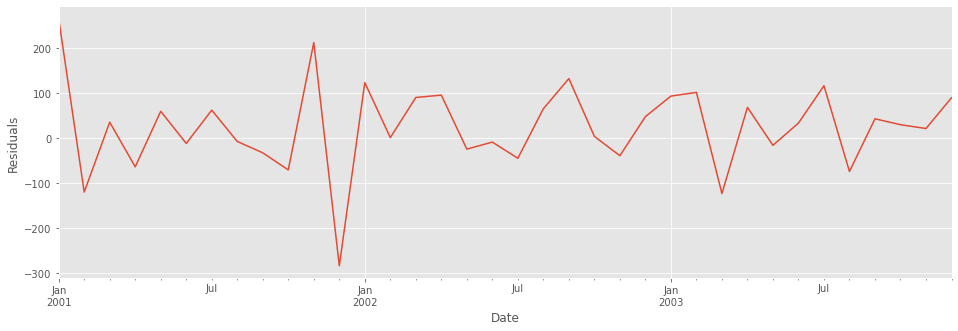

In [374]:
plt.figure(figsize(16,5))
best_model.resid.plot()
plt.ylabel('Residuals')
plt.show()

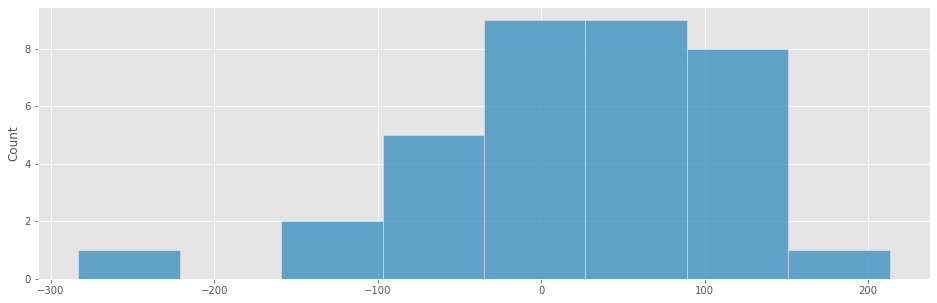

In [394]:
# Распределение не похоже на нормальное и имеет выбросы

sns.histplot(best_model.resid[1:]);

In [393]:
#  Проверим несмещенность с помощью критерия знаков

from statsmodels.stats.descriptivestats import sign_test
print("Критерий знаков для остатков: pvalue =",
      sign_test(best_model.resid[1:])[1])

# Медиана остатков не равна нулю. Распределение смещенное

Критерий знаков для остатков: pvalue = 0.31050465907901503


In [392]:
# Проверим гипотезу о не стационарности

print("Критерий Дики-Фуллера для остатков: pvalue =",
      sm.tsa.stattools.adfuller(best_model.resid[1:])[1])

# Гипотеза о нестационарности не отвергается

Критерий Дики-Фуллера для остатков: pvalue = 0.00022618538744345937


По критерию Льюнга-Бокса отвергается нулевая гипотеза о независимости отстатков

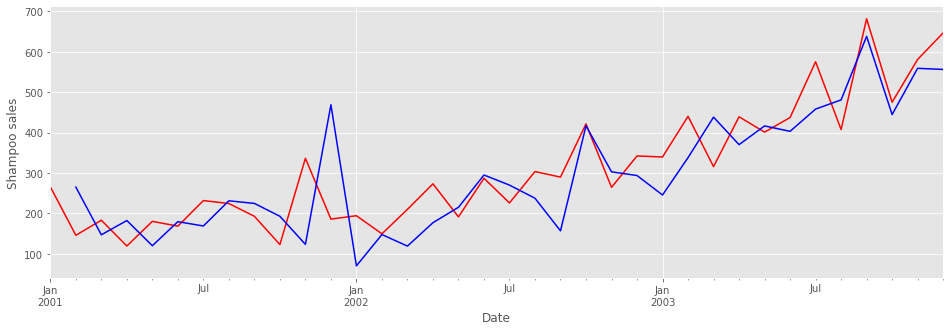

In [401]:
# Посмотрим на модель
# Основная линия тренда и колебания довольно похожи

data['model'] = best_model.fittedvalues
plt.figure(figsize(16,5))
data.Sales.plot(color='r')
data.model[1:].plot(color='b')

plt.ylabel('Shampoo sales')
pylab.show()

**Прогноз**

In [414]:
plot_data = data[['Sales','model']]

date_list = [datetime.datetime.strptime("2003-12-01", "%Y-%m-%d") + relativedelta(months=x) 
             for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns= plot_data.columns)
plot_data = pd.concat([plot_data, future])

plot_data.tail()

,Sales,model
2004-07-01,NaN,NaN
2004-08-01,NaN,NaN
2004-09-01,NaN,NaN
2004-10-01,NaN,NaN
2004-11-01,NaN,NaN


In [415]:
start = data.shape[0]
start

36

In [417]:
# построим предсказание на 3 года

forecast = best_model.predict(start=start, end=start+11)
forecast.index = date_list

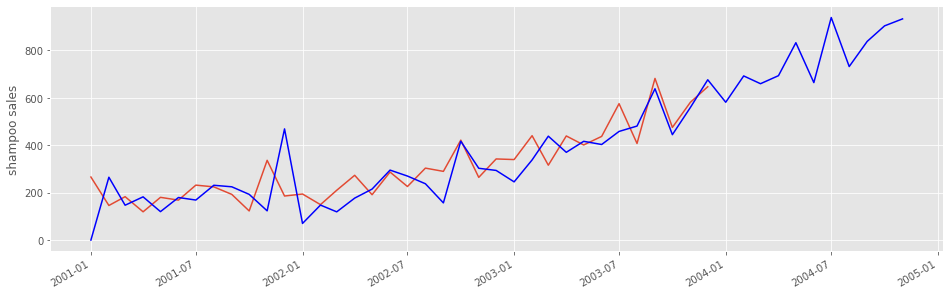

In [419]:
plot_data.loc[date_list, 'model'] = forecast

plt.figure(figsize(16,5))
plot_data.Sales.plot()
plot_data.model.plot(color='b')
plt.ylabel('shampoo sales')
pylab.show()

# Видим, что модель неплохо описывает ряд, но всегда совпадает в пиковых точка и что требует более детального анализа ряда